# **Prediksi Penutupan Harga Emas**



## 1. Install dan Import semua library yang dibutuhkan  

In [6]:
# 0. Install library
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow hyperopt streamlit -q

In [68]:
# 1. Import library
import yfinance as yf
import pandas as pd
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
import random
import numpy as np
import tensorflow as tf
# 2. Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

## 2. Data Understanding


### 2.1 Memuat DataSet
Tujuan: Memahami struktur dataset dan mengidentifikasi masalah data awal.
- Mengunduh dataset dari Yahoo  Finance
- Menampilkan 10 baris pertama untuk melihat format data
- Mengecek nilai yang hilang

In [69]:
data = yf.download('GC=F', start='2015-01-01', end='2025-01-01')
df = data[['Close']].copy()


[*********************100%***********************]  1 of 1 completed


In [72]:
# Simpan DataFrame Harga Emas ke CSV
df.to_csv('gold_price_dataset.csv', index=True)

In [52]:
# Menampilkan 10 baris pertama
df.head(10)

Price,Close
Ticker,GC=F
Date,
2015-01-02,1186.000000
2015-01-05,1203.900024
2015-01-06,1219.300049
2015-01-07,1210.599976
2015-01-08,1208.400024
2015-01-09,1216.000000
2015-01-12,1232.699951
2015-01-13,1234.300049


In [73]:
# Tampilkan informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2015-01-02 to 2024-12-31
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (Close, GC=F)  2513 non-null   float64
dtypes: float64(1)
memory usage: 39.3 KB


In [78]:
# Describe data
df['Close'].describe()

Ticker,GC=F
count,2513.000000
mean,1603.429008
std,393.086308
min,1050.800049
25%,1262.199951
50%,1526.599976
75%,1870.199951
max,2788.500000


### 2.2 Analisis Kualitas Data
Insight:
- Terdapat 2513 baris dataset
- **Tidak ada data yang kosong** - menunjukkan data relatif bersih


In [77]:
# Periksa nilai yang hilang
df.isnull().sum()

,,0
Price,Ticker,
Close,GC=F,0


## 3. Exploratory Data Analysis


### 3.1 Distribusi Harga Penutupan Emas

Kode di bawah ini digunakan untuk memvisualisasikan distribusi harga penutupan (close price) dari data emas menggunakan histogram dan kurva KDE (Kernel Density Estimate). Visualisasi dibuat dengan `seaborn.histplot()` untuk menampilkan frekuensi nilai pada kolom **'Close'** dalam bentuk batang histogram dan kurva distribusi. Parameter `kde=True` menambahkan kurva KDE untuk menunjukkan estimasi distribusi probabilitas.


**Insight:**
- Harga emas menunjukkan distribusi multimodal, dengan dua puncak utama di sekitar harga 1250 dan 1800.
- Terdapat rentang harga yang cukup lebar, dari sekitar 1050 hingga lebih dari 2700.
- Pola ini bisa mencerminkan beberapa periode tren pasar yang berbeda, seperti bullish dan bearish.


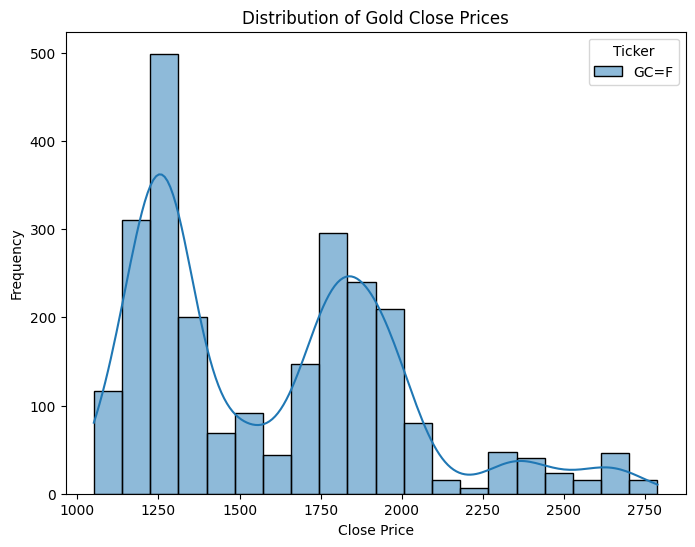

In [54]:
# Memvisualisasikan distribusi harga 'Close'
plt.figure(figsize=(8, 6))
sns.histplot(df['Close'], kde=True)
plt.title('Distribution of Gold Close Prices')
plt.xlabel('Close Price')
plt.ylabel('Frequency')
plt.show()

### 3.2 Visualisasi Tren Penutupan Harga Emas

Kode di bawah ini membuat line chart untuk memvisualisasikan pergerakan harga emas (Close) dari tahun 2015 hingga 2025 ( 10 tahun).

**Insight:**
- Harga emas mengalami tren naik signifikan sejak 2019, dengan lonjakan tajam terutama di tahun 2020 dan 2024.
- Pergerakan harga cukup volatil, namun secara keseluruhan menunjukkan arah bullish (naik).
- Lonjakan besar pada tahun 2020 kemungkinan berkaitan dengan ketidakpastian ekonomi global (misalnya pandemi COVID-19).


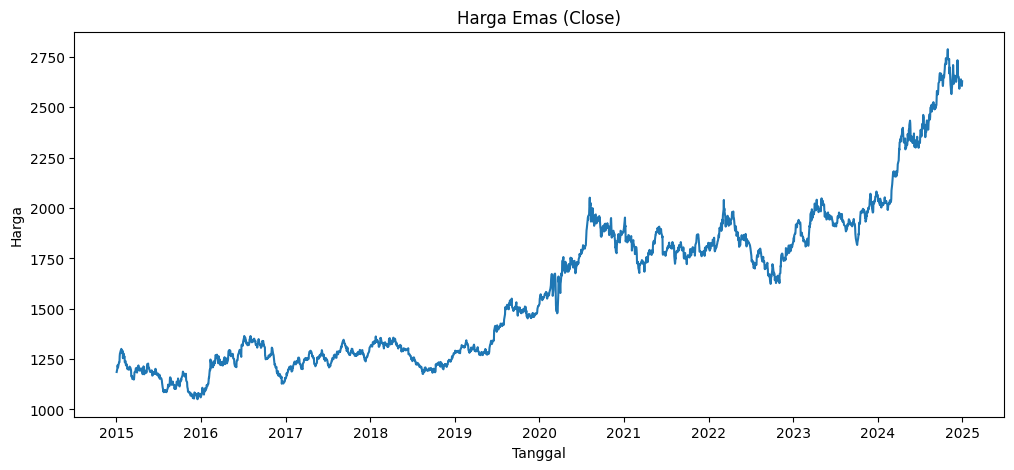

In [59]:
# Plot Grafik harga emas
def plot_close(series, title="Harga Emas (Close)"):
    plt.figure(figsize=(12,5))
    plt.plot(series)
    plt.title(title)
    plt.xlabel('Tanggal'), plt.ylabel('Harga')
    plt.show()
plot_close(df['Close'])

## 4. Data Preparation
- Karena data sudah bersih, jadi tidak dilakukan pembersihan data
- Normalisasi dan Pembentukan Data Time Series
- Pembagian Dataset Time Series (Train, Validation, Test)  

### 4.1 Normalisasi dan Pembentukan Data Time Series untuk Model GRU  
**Fungsi Kode**:  
Kode ini bertujuan untuk menyiapkan data time series agar dapat digunakan dalam model deep learning seperti GRU. Proses ini meliputi normalisasi data harga penutupan dan pembentukan data dalam bentuk sekuens sliding window.

**Langkah-langkah**:
1. **Normalisasi Data**:
   - Kolom `'Close'` dinormalisasi ke dalam rentang [0, 1] menggunakan `MinMaxScaler()` dari `sklearn`, dan hasilnya disimpan ke kolom baru `'Close_s'`.
   - Tujuannya adalah agar model lebih mudah belajar dan konvergen lebih cepat saat training.

2. **Fungsi Pembentukan Sekuens**:
   - Fungsi `create_sequences()` membuat data input `X` dan target `y` untuk model time series.
   - Menggunakan pendekatan *sliding window* sebesar `window_size`, yaitu 60 data sebelumnya digunakan untuk memprediksi data ke-61.
   - Data input (`X`) berupa array 2D dari sekuens, dan target (`y`) adalah nilai setelah sekuens.

3. **Penerapan dan Reshape**:
   - Nilai series diambil dari kolom `'Close_s'` yang telah dinormalisasi.
   - Data `X` dibentuk ulang ke dalam dimensi `(samples, timesteps, features)` menjadi `(N, 60, 1)`, sesuai input standar model GRU.



4. **Output Dimensi**:
   - Dicetak dimensi hasil `X` dan `y` untuk memastikan bentuk input sudah sesuai.


**Keuntungan**:
- Normalisasi membantu mempercepat konvergensi model dan menghindari dominasi fitur dengan skala besar.
- Pembentukan sekuens memungkinkan pemodelan dependensi temporal yang sangat penting dalam prediksi time series.
- Format `(samples, timesteps, features)` kompatibel langsung dengan arsitektur GRU di Keras atau PyTorch.

**Insight**:
- Proses ini menghasilkan pasangan input-output yang merepresentasikan dinamika harga emas dalam 60 hari terakhir untuk memprediksi harga hari berikutnya.
- Ideal untuk digunakan dalam model GRU karena menangkap pola historis dan fluktuasi jangka pendek secara eksplisit.



In [9]:
df_scaler = MinMaxScaler()
df['Close_s'] = df_scaler.fit_transform(df[['Close']])
def create_sequences(series, window_size):
    X, y = [], []
    for i in range(len(series)-window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    return np.array(X), np.array(y)
WINDOW = 60
series = df['Close_s'].values
X, y = create_sequences(series, WINDOW)
X = X.reshape((X.shape[0], WINDOW, 1))
print(f"Shape X: {X.shape}, y: {y.shape}")

Shape X: (2453, 60, 1), y: (2453,)



### 4.2 Pembagian Dataset Time Series (Train, Validation, Test)  
**Fungsi Kode**:  
Kode ini digunakan untuk membagi dataset yang telah dibentuk menjadi sekuens menjadi tiga bagian utama: **training**, **validation**, dan **testing**, sesuai dengan proporsi yang umum digunakan dalam pelatihan model machine learning dan deep learning.

**Langkah-langkah**:
1. **Menentukan Ukuran Dataset**:
   - Variabel `total` menyimpan jumlah total sampel dalam array `X`.
   - Indeks akhir untuk data training dan validation dihitung berdasarkan proporsi:
     - 70% untuk **train**
     - 15% untuk **validation**
     - 15% sisanya untuk **test**



2. **Pembagian Dataset**:
   - Data dibagi menggunakan slicing berdasarkan indeks yang telah dihitung:
     - `X_train`, `y_train` untuk pelatihan model.
     - `X_val`, `y_val` untuk validasi selama proses pelatihan.
     - `X_test`, `y_test` untuk evaluasi akhir performa model.



3. **Pengecekan Bentuk Data**:
   - Menampilkan ukuran masing-masing subset untuk memastikan pembagian data sudah sesuai proporsi dan tidak terjadi kehilangan data.


**Keuntungan**:
- Pembagian data secara berurutan (bukan acak) menjaga urutan temporal pada data time series, yang penting untuk menghindari *data leakage*.
- Memberikan struktur yang baik untuk pelatihan, tuning, dan evaluasi model secara terpisah.
- Memastikan generalisasi model tidak hanya berdasarkan data yang pernah dilihat selama pelatihan.

**Insight**:
- Proporsi 70:15:15 merupakan pilihan seimbang untuk proyek deep learning skala sedang.
- Validation set digunakan untuk menghindari overfitting, sedangkan test set akan mencerminkan kemampuan model pada data nyata yang belum pernah dilihat.



In [10]:
total = len(X)
train_end = int(total*0.7)
val_end = train_end + int(total*0.15)
X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1717, 60, 1), Val: (367, 60, 1), Test: (369, 60, 1)


## 5. Pembangunan dan Evaluasi Model GRU (Tuning)  

### 5.1 Hyperparameter Tuning GRU dengan Hyperopt
**Fungsi Kode**:  
Fungsi ini digunakan untuk pencarian kombinasi hyperparameter terbaik dengan model GRU menggunakan `Hyperopt`.

**Langkah-langkah**:
1. **Penetapan Seed (Reproducibility)**:
   - Seed untuk `random`, `numpy`, dan `tensorflow` diset untuk memastikan hasil eksperimen konsisten dan dapat direproduksi.


2. **Arsitektur Model**:
   - Model didefinisikan sebagai `Sequential` dengan tiga lapisan utama:
     - `Input`: Berbentuk `(WINDOW, 1)` sesuai format time series.
     - `GRU`: Layer utama yang mempelajari dependensi temporal, jumlah unit disesuaikan dari parameter.
     - `Dropout`: Regularisasi untuk mencegah overfitting.
     - `Dense`: Output layer dengan satu neuron untuk regresi harga.

3. **Kompilasi Model**:
   - Optimizer yang digunakan adalah **Adam**, dengan `learning_rate` yang diatur lewat parameter.
   - Fungsi loss yang digunakan adalah **mean squared error (MSE)**, cocok untuk regresi.

4. **Pelatihan Model**:
   - Model dilatih menggunakan `fit()` dengan:
     - `X_train`, `y_train` sebagai data latih.
     - `X_val`, `y_val` sebagai data validasi.
     - `EarlyStopping` memantau `val_loss` dan menghentikan pelatihan jika tidak membaik selama 5 epoch.
     - Semua parameter pelatihan (epoch, batch size) diambil dari dictionary `params`.

5. **Evaluasi**:
   - Nilai minimum dari `val_loss` diambil sebagai metrik evaluasi dan dikembalikan sebagai output fungsi.

**Fungsi**
- Fungsi `build_evaluate()` membuat dan melatih model GRU berdasarkan parameter input, lalu mengembalikan **val_loss** terbaik.
- `space` mendefinisikan ruang pencarian hyperparameter: units, dropout, learning rate, batch size, dan epochs.
- `fmin()` menjalankan pencarian sebanyak 20 iterasi dengan algoritma Tree-structured Parzen Estimator (TPE).
- Hasil terbaik dikonversi dan disimpan dalam `best_params`.

**Output**:
- Parameter GRU terbaik untuk performa validasi optimal.

**Keuntungan**:
- Fungsi ini modular dan fleksibel, sehingga cocok digunakan dalam *grid search* atau *random search* untuk mencari konfigurasi terbaik.
- Menyediakan regularisasi dan early stopping untuk mencegah overfitting.

**Insight**:
- Model GRU lebih ringan dibandingkan LSTM namun tetap efektif untuk menangani dependensi temporal.
- Pemilihan `val_loss` sebagai metrik tuning penting agar model tidak hanya bagus di training tetapi juga di generalisasi.



In [11]:
def build_evaluate(params):
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Input(shape=(WINDOW,1)))
    # 1 Layer GRU dengan units parameter
    model.add(GRU(int(params['units']), return_sequences=False))
    model.add(Dropout(params['dropout']))
    model.add(Dense(1))
    model.compile(
        optimizer=Adam(learning_rate=params['lr']),
        loss='mse'
    )
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=int(params['epochs']),
        batch_size=int(params['batch_size']),
        callbacks=[es],
        verbose=0
    )
    val_loss = min(history.history['val_loss'])
    return val_loss

In [12]:
space = {
    'units':      hp.quniform('units',     32, 96, 16), # units 32–96, step 16
    'dropout':    hp.uniform('dropout',    0.23, 0.43),
    'lr':         hp.loguniform('lr',
                                np.log(1e-4),  # ~0.0001
                                np.log(1e-2)), # ~0.01
    'batch_size': hp.choice('batch_size', [ 16, 32, 48]),
    'epochs':     hp.choice('epochs',     [50, 100, 150]),
}


In [13]:
trials = Trials()
best = fmin(
    fn=lambda p: build_evaluate(p),
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)
print("Best params:", best)

100%|██████████| 20/20 [19:39<00:00, 58.98s/trial, best loss: 0.00011424332478782162]
Best params: {'batch_size': np.int64(0), 'dropout': np.float64(0.4025344556568261), 'epochs': np.int64(1), 'lr': np.float64(0.005808838733705406), 'units': np.float64(80.0)}


In [14]:
# Konversi params terbaik
best_params = {
    'units': int(best['units']),
    'dropout': best['dropout'],
    'lr': best['lr'],
    'batch_size': [16, 32, 48][best['batch_size']],
    'epochs': [50, 100, 150][best['epochs']]
}
print("Converted best params:", best_params)

Converted best params: {'units': 80, 'dropout': np.float64(0.4025344556568261), 'lr': np.float64(0.005808838733705406), 'batch_size': 16, 'epochs': 100}


### 5.2 Pelatihan Model GRU dengan Parameter Terbaik  
**Fungsi Kode**:  
Kode ini digunakan untuk **melatih model GRU akhir** menggunakan kombinasi hyperparameter terbaik (`best_params`) yang telah diperoleh dari proses tuning sebelumnya. Model ini dilatih menggunakan data yang telah dibagi dan distandarkan sebelumnya.

**Langkah-langkah**:
1. **Penetapan Seed TensorFlow**:
   - Seed disetel agar hasil pelatihan model dapat direproduksi dan stabil.

2. **Pembangunan Model GRU**:
   - `Sequential` model dibentuk dengan tiga layer utama:
     - `Input`: menerima input time series berbentuk `(WINDOW, 1)`.
     - `GRU`: layer utama untuk menangkap pola temporal, jumlah unit sesuai `best_params['units']`.
     - `Dropout`: mencegah overfitting sesuai dengan `best_params['dropout']`.
     - `Dense`: layer output untuk regresi (1 output).

3. **Kompilasi Model**:
   - Optimizer: `Adam` dengan `learning_rate` dari `best_params`.
   - Loss function: `Mean Squared Error (MSE)` karena targetnya adalah nilai numerik (regresi).

4. **Pelatihan Model**:
   - Model dilatih dengan:
     - `X_train` dan `y_train` sebagai data latih.
     - `X_val` dan `y_val` untuk memantau performa validasi.
     - **EarlyStopping** diterapkan untuk menghentikan pelatihan jika `val_loss` tidak membaik selama 10 epoch.
     - Pelatihan menggunakan `shuffle=False` karena ini data time series (urutan harus dijaga).
     - Parameter `epochs` dan `batch_size` berasal dari `best_params`.

**Keuntungan**:
- Kombinasi hyperparameter optimal meningkatkan akurasi dan generalisasi model.
- EarlyStopping mencegah overfitting dengan menghentikan pelatihan saat validasi tidak membaik.
- Menggunakan `shuffle=False` sangat penting untuk menjaga urutan time series yang merefleksikan kronologi nyata.

**Insight**:
- Model yang dilatih dengan parameter optimal dan validasi yang baik akan lebih andal dalam memprediksi tren harga emas.
- Kehadiran Dropout dan EarlyStopping menunjukkan perhatian terhadap overfitting yang umum terjadi dalam deep learning.


In [15]:
tf.random.set_seed(42)
model_gru = Sequential([
    Input(shape=(WINDOW,1)),
    GRU(best_params['units']),
    Dropout(best_params['dropout']),
    Dense(1)
])
model_gru.compile(
    optimizer=Adam(learning_rate=best_params['lr']),
    loss='mse'
)
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    callbacks=[es],
    shuffle=False,
    verbose=2
)

Epoch 1/100
108/108 - 13s - 120ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 2/100
108/108 - 13s - 123ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 3/100
108/108 - 6s - 52ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 4/100
108/108 - 4s - 39ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 5/100
108/108 - 5s - 47ms/step - loss: 0.0055 - val_loss: 0.0018
Epoch 6/100
108/108 - 5s - 47ms/step - loss: 0.0054 - val_loss: 0.0027
Epoch 7/100
108/108 - 5s - 47ms/step - loss: 0.0052 - val_loss: 0.0021
Epoch 8/100
108/108 - 6s - 53ms/step - loss: 0.0047 - val_loss: 0.0032
Epoch 9/100
108/108 - 4s - 40ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 10/100
108/108 - 6s - 52ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 11/100
108/108 - 3s - 31ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 12/100
108/108 - 5s - 43ms/step - loss: 0.0026 - val_loss: 5.3727e-04
Epoch 13/100
108/108 - 3s - 27ms/step - loss: 0.0017 - val_loss: 4.6397e-04
Epoch 14/100
108/108 - 5s - 47ms/step - loss: 0.0012 - val_lo

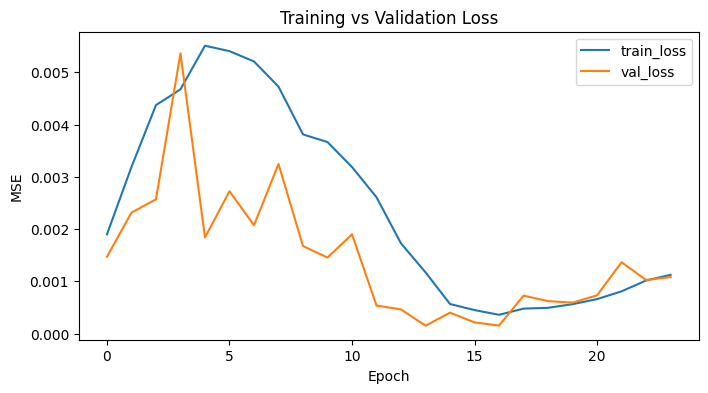

(Text(0.5, 24.0, 'Epoch'),
 Text(24.0, 0.5, 'MSE'),
 None)

In [16]:
# Plot training vs validation loss
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch'), plt.ylabel('MSE'), plt.legend(), plt.show()



###  **Insight:**

1. **Overfitting Tidak Terjadi Secara Signifikan**  
   - Kurva `val_loss` dan `train_loss` menunjukkan pola yang cukup selaras, terutama setelah epoch ke-10 hingga akhir. Ini mengindikasikan bahwa model tidak mengalami overfitting serius.
   - Setelah awal yang fluktuatif, `val_loss` menjadi lebih stabil dan rendah.

2. **Performa Model Membaik Seiring Waktu**  
   - Kedua loss turun secara umum seiring bertambahnya epoch. Ini menunjukkan bahwa model belajar dengan baik dari data.

3. **Awal Training Tidak Stabil**  
   - Terlihat bahwa pada awal (sekitar epoch ke-4), `val_loss` sempat melonjak tajam sebelum akhirnya menurun. Ini umum terjadi dan bisa disebabkan oleh pembelajaran awal model yang belum optimal.


## 6. Evaluasi Model GRU pada Data Testing  
**Fungsi Kode**:  
Kode ini digunakan untuk mengevaluasi performa model GRU pada **data testing**, dengan mengukur berbagai metrik regresi setelah hasil prediksi dikembalikan ke skala aslinya (inverse transform).

**Langkah-langkah**:
1. **Prediksi pada Data Testing**:
   - Model GRU melakukan prediksi terhadap `X_test`.
   - Hasil prediksi (`y_pred_s`) diratakan dengan `.flatten()` agar satu dimensi.

2. **Inverse Transform ke Skala Asli**:
   - Karena data sebelumnya telah dinormalisasi dengan `MinMaxScaler`, maka nilai asli perlu dikembalikan dengan `inverse_transform()`:
     - `y_test_true`: nilai aktual yang telah dikembalikan ke skala asli.
     - `y_pred_true`: hasil prediksi model dalam skala asli.

3. **Menghitung Metrik Evaluasi**:
   - **RMSE (Root Mean Squared Error)**: rata-rata akar kuadrat dari error prediksi.
   - **MAE (Mean Absolute Error)**: rata-rata absolut selisih antara prediksi dan nilai aktual.
   - **MAPE (Mean Absolute Percentage Error)**: rata-rata persentase kesalahan terhadap nilai aktual.
   - **R² (R-squared Score)**: proporsi variansi yang dijelaskan oleh model (nilai mendekati 1 lebih baik).

**Keuntungan**:
- Evaluasi menggunakan banyak metrik memberikan pemahaman menyeluruh terhadap performa model.
- Transformasi balik ke skala asli memudahkan interpretasi hasil oleh pengguna non-teknis.

**Insight**:
- Nilai RMSE dan MAE yang kecil menunjukkan prediksi model akurat.
- MAPE di bawah 10% umumnya dianggap sangat baik untuk model prediktif.
- Nilai R² mendekati 1 menunjukkan model mampu menjelaskan variansi data dengan baik.


In [17]:
y_pred_s = model_gru.predict(X_test).flatten()
y_test_true = df_scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_true = df_scaler.inverse_transform(y_pred_s.reshape(-1,1)).flatten()
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred_true))
mae  = mean_absolute_error(y_test_true, y_pred_true)
mape = np.mean(np.abs((y_test_true-y_pred_true)/y_test_true))*100
r2   = r2_score(y_test_true, y_pred_true)
print(f"Test RMSE: {rmse:.2f}, MAE: {mae:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Test RMSE: 31.07, MAE: 24.33, MAPE: 1.03%, R2: 0.9874


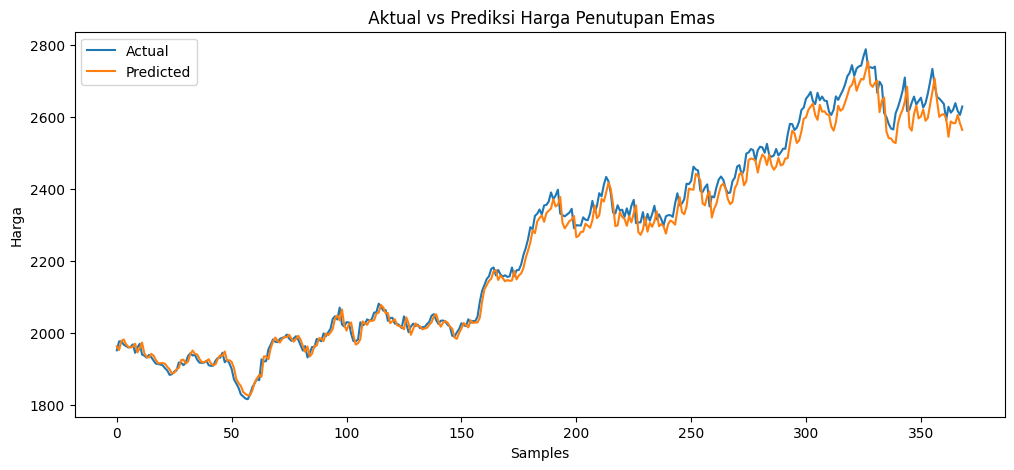

(Text(0.5, 24.0, 'Samples'),
 Text(24.0, 0.5, 'Harga'),
 None)

In [18]:
# Plot actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test_true, label='Actual')
plt.plot(y_pred_true, label='Predicted')
plt.title(' Aktual vs Prediksi Harga Penutupan Emas')
plt.xlabel('Samples'), plt.ylabel('Harga'), plt.legend(), plt.show()


### **Insight:**

- **Prediksi Model Cukup Akurat**  
   Garis prediksi (`Predicted`) sangat mendekati garis aktual (`Actual`) hampir di seluruh rentang data, yang menunjukkan bahwa model memiliki kemampuan prediksi yang baik.

- **Pola Tren Terjaga**  
   Model mampu mengikuti tren naik dan turun harga emas dengan cukup baik, termasuk lonjakan dan penurunan tajam. Ini menunjukkan bahwa model berhasil menangkap pola temporal yang penting dari data.

- **Sedikit Lag atau Deviasi**  
   Terdapat beberapa momen di mana prediksi tertinggal atau tidak setepat data aktual (misalnya pada puncak harga sekitar sample ke-320 dan setelahnya). Namun, perbedaannya relatif kecil.




## 7. Menyimpan Model dan Scaler  
**Fungsi Kode**:  
Menyimpan model GRU terlatih dan scaler `MinMaxScaler` agar bisa digunakan kembali tanpa melatih ulang.

**Langkah-langkah**:
- `model_gru.save()`: menyimpan model ke file `best_model_gru.h5`.
- `pickle.dump()`: menyimpan scaler ke file `scaler_close.pkl`.

**Output**:
- File `.h5` dan `.pkl` siap dipakai untuk prediksi di masa depan.


In [19]:
model_gru.save('best_model_gru.h5')
import pickle
pickle.dump(df_scaler, open('scaler_close.pkl','wb'))
print('Best GRU model dan scaler disimpan sebagai best_model_gru.h5 & scaler_close.pkl')

Best GRU model dan scaler disimpan sebagai best_model_gru.h5 & scaler_close.pkl


## 8. Interface

### 8.1. Prediksi Harga Emas 30 Hari Mendatang
**Fungsi Kode**:  
Kode ini digunakan untuk **melakukan prediksi harga emas selama 30 hari ke depan** berdasarkan harga 100 hari terakhir menggunakan model GRU yang telah dilatih sebelumnya.

**Langkah-langkah**:
- Memuat model dan scaler.
- Ambil data `Close` 100 hari terakhir, normalisasi, lalu prediksi 1 hari ke depan sebanyak 30 kali (multistep).
- Setiap hasil prediksi ditambahkan ke input untuk prediksi berikutnya.

**Output**:
- Grafik prediski penutupan harga emas 30 hari mendatang



In [27]:
## Melakukan  Interface
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.losses import MeanSquaredError

# Memuat model terlatih dan scaler
model = load_model('best_model_gru.h5', custom_objects={'mse': MeanSquaredError()})
scaler = pickle.load(open('scaler_close.pkl', 'rb'))

def predict_gold_price_30days():
    data = yf.download('GC=F', period='100d')  # Mengabil data 100 hari terakhir
    new_df = data[['Close']].copy()
    new_df['Close_s'] = scaler.transform(new_df[['Close']])
    series = new_df['Close_s'].values
    WINDOW = 60
    predictions = []

    if len(series) < WINDOW:
        print("Not enough data points. Please extend the data range.")
        return None

    # Prediksi untuk 30 hari ke depan
    for i in range(30):
        X_new = series[-WINDOW:].reshape(1, WINDOW, 1)
        y_pred_s = model.predict(X_new).flatten()
        y_pred_true = scaler.inverse_transform(y_pred_s.reshape(-1, 1)).flatten()
        predictions.append(y_pred_true[0])

        # Perbarui seri dengan nilai prediksi untuk iterasi berikutnya
        series = np.append(series, y_pred_s)

    return predictions


[*********************100%***********************]  1 of 1 completed

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

[*********************100%***********************]  1 of 1 completed


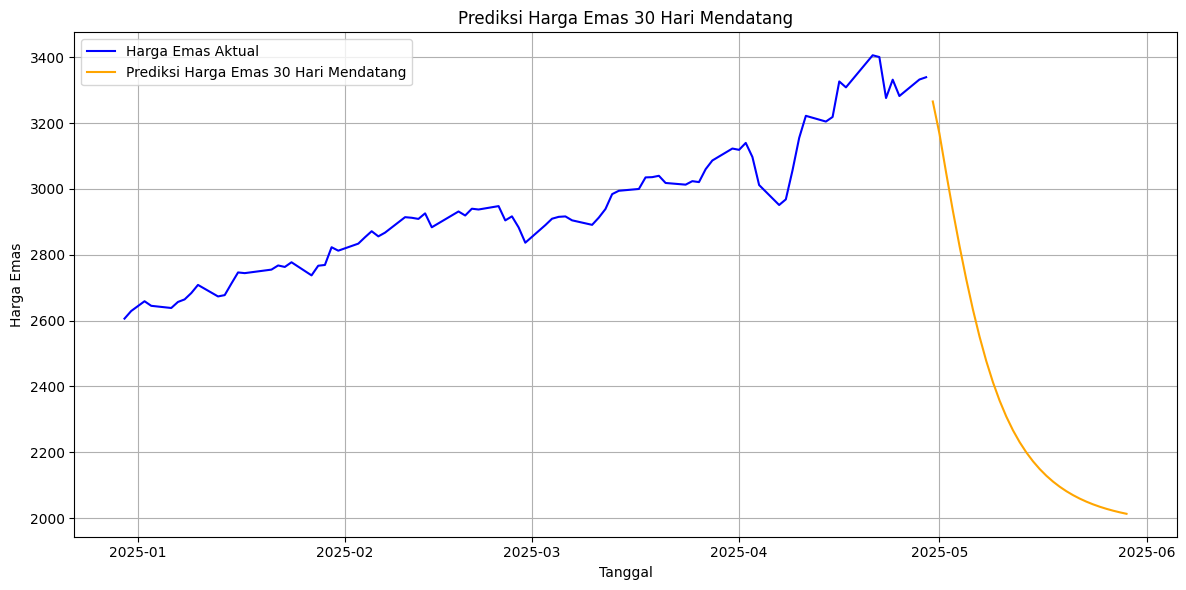

In [66]:
predicted_prices_30days = predict_gold_price_30days()

if predicted_prices_30days:
    data = yf.download('GC=F', period='100d')
    actual_prices = data['Close']

    plt.figure(figsize=(12, 6))
    plt.plot(actual_prices.index, actual_prices.values, label='Harga Emas Aktual', color='blue')

    # Hasilkan tanggal prediksi
    last_date = actual_prices.index[-1]
    prediction_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

    plt.plot(prediction_dates, predicted_prices_30days, label='Prediksi Harga Emas 30 Hari Mendatang', color='orange')
    plt.xlabel('Tanggal')
    plt.ylabel('Harga Emas')
    plt.title('Prediksi Harga Emas 30 Hari Mendatang')
    plt.legend()
    plt.grid(True)
    plt.xticks()
    plt.tight_layout()
    plt.show()

## 9. Conclusion




###  **Evaluasi Model - Insight dari Metrik**

| Metrik   | Nilai   | Interpretasi                                                                 |
|----------|---------|------------------------------------------------------------------------------|
| **RMSE** | 31.07   | Kesalahan prediksi rata-rata sekitar 31 unit harga emas — cukup rendah.      |
| **MAE**  | 24.33   | Rata-rata deviasi absolut dari nilai aktual adalah 24.33 unit.               |
| **MAPE** | 1.03%   | Model hanya meleset sekitar 1% dari nilai aktual secara rata-rata — sangat akurat. |
| **R²**   | 0.9874  | Model menjelaskan **98.74%** variansi dari data — performa sangat baik.       |





### 9.1 Ringkasan Hasil  
- **Model prediksi harga emas** menunjukkan performa sangat baik pada data uji dengan **RMSE: 31.07**, **MAE: 24.33**, dan **MAPE: 1.03%**.  
- **Nilai R² sebesar 0.9874** menunjukkan bahwa model mampu menjelaskan hampir seluruh variansi harga emas aktual.  
- Grafik *Actual vs Predicted* memperlihatkan prediksi mengikuti pola harga emas dengan sangat akurat, tanpa deviasi yang signifikan.  
- Grafik *Training vs Validation Loss* menunjukkan proses pelatihan yang stabil tanpa tanda overfitting, dengan tren loss menurun dan konsisten.
-  Prediksi Harga Emas 30 Hari Mendatang penurunan harga emas


### 9.2 Business Decisions
- Bukan Saat yang Tepat untuk FOMO Investasi Emas
Prediksi model menunjukkan potensi penurunan harga emas dalam waktu dekat. Meski tren historis menunjukkan kenaikan, sinyal teknikal dari model saat ini tidak mendukung aksi beli agresif (FOMO).

- Strategi Menunggu dan Lihat (Wait-and-See)
Investor disarankan untuk menunggu konfirmasi pergerakan harga emas selama beberapa hari ke depan sebelum melakukan aksi beli. Ini dapat menghindari potensi kerugian dari harga yang mungkin terus turun.

- Manfaatkan Penurunan Sebagai Peluang
Jika harga turun sesuai prediksi, kondisi tersebut bisa dimanfaatkan sebagai entry point jangka panjang yang lebih menguntungkan, dengan syarat pemantauan terus-menerus terhadap indikator pasar lainnya.

- Diversifikasi Portofolio
Alih-alih hanya fokus pada emas, investor dapat mempertimbangkan instrumen lain seperti saham, crypto, obligasi, atau komoditas lain untuk mengurangi risiko dan volatilitas dari satu aset saja.

- Evaluasi Data Eksternal dan Sentimen Pasar
Mengingat prediksi penurunan ini bertentangan dengan tren historis, sangat disarankan menggabungkan data makroekonomi dan faktor geopolitik sebagai bahan pertimbangan sebelum keputusan investasi diambil.